In [1]:
import numpy as np
from os.path import dirname, abspath, join as pjoin
from Corrfunc.theory.DD import DD
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.mocks import *
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import glob, time 

from astropy.io import fits as fits
from astropy.table import Table, vstack
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import healpy as hp
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.targets import desi_mask, bgs_mask, mws_mask 
from desitarget.geomask import get_imaging_maskbits 

First I trial it with the catalog they provide: 

In [24]:
# Read the supplied galaxies on a periodic box
X, Y, Z = read_catalog()
N = len(X)
boxsize = 420.0
nthreads = 2

# Generate randoms on the box
rand_N = 3*N
rand_X = np.random.uniform(0, boxsize, rand_N)
rand_Y = np.random.uniform(0, boxsize, rand_N)
rand_Z = np.random.uniform(0, boxsize, rand_N)

# Setup the bins
nbins = 10
bins = np.linspace(0.1, 10.0, nbins + 1) # note that +1 to nbins

# Auto pair counts in DD
autocorr=1
DD_counts = DD(autocorr, nthreads, bins, X, Y, Z, periodic=False, verbose=True)

# Cross pair counts in DR
autocorr=0
DR_counts = DD(autocorr, nthreads, bins, X, Y, Z, X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic=False, verbose=True)

# Auto pairs counts in RR
autocorr=1
RR_counts = DD(autocorr, nthreads, bins, rand_X, rand_Y, rand_Z,periodic=False, verbose=True)

# All the pair counts are done, get the correlation function
cf = convert_3d_counts_to_cf(N, N, rand_N, rand_N,DD_counts, DR_counts,DR_counts, RR_counts)



In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,41,41.  Time taken =   0.078 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.865 secs
ND1 =      1235904 [xmin,ymin,zmin] = [0.000400,0.000100,0.000300], [xmax,ymax,zmax] = [419.999817,419.999512,419.999207]
ND2 =      3707712 [xmin,ymin,zmin] = [0.000066,0.000100,0.000150], [xmax,ymax,zmax] = [419.999973,419.999910,419.999574]
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,41,41.  Time taken =   0.071 sec
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,41,41.  Time taken =   0.733 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  3.050 secs
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 41,41,41.  Time taken =   0.737 sec
0%.........10%.........20%.........30%........

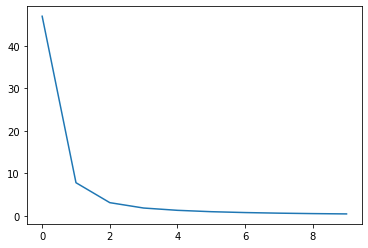

In [9]:
plt.plot(cf)

Trying to find the projected correlation function for mxxl:

In [ ]:
import numpy as np
import Corrfunc
from Corrfunc.mocks.DDrppi_mocks import DDrppi_mocks
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_rp_pi_counts_to_wp
from astropy.cosmology import WMAP9 as cosmo
from Corrfunc.utils import convert_to_native_endian 
 

# Read the supplied galaxies on a periodic box
f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.9.fits')
mxxl=f[1].data

RA = convert_to_native_endian(mxxl['RA'])
DEC = convert_to_native_endian(mxxl['DEC'])
CZ =convert_to_native_endian( np.array(cosmo.comoving_distance(mxxl['Z'])))
N = len(RA)

# Read the supplied randoms catalog
f = fits.open('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/random0/rancomb_brightwdup_Alltiles.fits')
random1=f[1].data

rand_RA = convert_to_native_endian(random1['RA'])
rand_DEC = convert_to_native_endian(random1['DEC'])

rand_CZ= convert_to_native_endian(np.array(list(CZ)))
np.random.shuffle(rand_CZ)
rand_N = len(rand_RA)




# Setup the bins
nbins = 10
bins = np.linspace(0.1, 25.0, nbins + 1)
pimax = 40.0

cosmology = 1
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDrppi_mocks(autocorr, cosmology, nthreads, pimax, bins,RA, DEC, CZ)


# Cross pair counts in DR
autocorr=0
DR_counts = DDrppi_mocks(autocorr, cosmology, nthreads, pimax, bins,RA, DEC, CZ,RA2=rand_RA, DEC2=rand_DEC, CZ2=rand_CZ)


# Auto pairs counts in RR
autocorr=1
RR_counts = DDrppi_mocks(autocorr, cosmology, nthreads, pimax, bins,rand_RA, rand_DEC, rand_CZ)

# All the pair counts are done, get the angular correlation function
wp = convert_rp_pi_counts_to_wp(N, N, rand_N, rand_N,DD_counts, DR_counts,DR_counts, RR_counts, nbins, pimax)

In [4]:
wp

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [2]:
#main survey data: files are in healpixels so this just creates a big file of them all 
#and makes cuts so it's bgs only 

#working with main survey randoms here i.e not sv3
to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/main/bright/mtl-bright-hp-*.ecsv') 

# very good practice to apply sorted, otherwise the file ordering will be random 	and non-repeatable.  
to_grab = sorted(to_grab) 

hp_stack = []

#do timer as takes a while
start = time.time() 

#total number of pixels, not quite sure where this has come from as npix is less than this above 
npix_todo = 200000

mmask = 'BGS_TARGET'
ttype = 'BGS_BRIGHT'

#loop through pixels
for i, x in enumerate(to_grab):
    x = pd.read_csv(x, comment='#', delimiter='\s+', usecols=['RA', 'DEC', 'TARGETID', 'BGS_TARGET', 'MWS_TARGET'])

    #mask for bgs objects
    is_bgs = (x[mmask] & bgs_mask[ttype]) != 0
    idx = np.arange(len(x))[is_bgs]
    x = x.iloc[idx] 
    hp_stack.append(x)

    #more timing stuff
    if (i % 100) == 0:
        runtime = (time.time() - start)

        print('Runtime of {:.6f} seconds after {:d} pixels'.format(runtime, i))

    if i > npix_todo:
        break
        
# Create a big table from the list of tables.  
data_stack = pd.concat(hp_stack, ignore_index=True)

#unique targets only and put it in right table format
mask,idx = np.unique(data_stack['TARGETID'],return_index=True)
data_stack = data_stack.iloc[idx]
data_stack = Table.from_pandas(data_stack)

#more timing stuff
runtime = (time.time() - start)
print('\n\nTotal runtime of {:.6f} seconds after {:d} pixels'.format(runtime, npix_todo))

data_stack

Runtime of 0.054786 seconds after 0 pixels
Runtime of 3.926874 seconds after 100 pixels
Runtime of 10.455444 seconds after 200 pixels
Runtime of 16.081413 seconds after 300 pixels
Runtime of 23.894085 seconds after 400 pixels
Runtime of 30.687874 seconds after 500 pixels
Runtime of 36.254425 seconds after 600 pixels
Runtime of 42.637500 seconds after 700 pixels
Runtime of 50.185276 seconds after 800 pixels
Runtime of 55.663013 seconds after 900 pixels
Runtime of 61.116721 seconds after 1000 pixels
Runtime of 66.835728 seconds after 1100 pixels
Runtime of 74.776762 seconds after 1200 pixels
Runtime of 83.310304 seconds after 1300 pixels
Runtime of 92.400433 seconds after 1400 pixels
Runtime of 98.380402 seconds after 1500 pixels
Runtime of 105.325092 seconds after 1600 pixels
Runtime of 112.089290 seconds after 1700 pixels
Runtime of 119.468570 seconds after 1800 pixels
Runtime of 125.493064 seconds after 1900 pixels
Runtime of 132.771437 seconds after 2000 pixels
Runtime of 140.012080 

RA,DEC,TARGETID,BGS_TARGET,MWS_TARGET
float64,float64,int64,int64,int64
59.60086559409994,-68.12683131313392,39626498281308189,131074,0
60.00983139575825,-68.16966639837612,39626498281308607,131074,0
60.01124019929327,-68.16379040745758,39626498281308610,131074,0
60.067316634746724,-68.1403940503445,39626498281308675,131074,0
60.27687723658043,-68.1477166136955,39626498285502547,131074,0
60.351730827700045,-68.1384524183673,39626498285502613,131074,0
60.35480903565853,-68.15736062454609,39626498285502619,131074,0
60.41502834204189,-68.14758441322456,39626498285502711,131074,0
60.57191230896668,-68.15293728255374,39626498285502939,131074,0


In [ ]:
#angular correlation function for mock data.  This is based on SV3 so use different randoms 

import numpy as np
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf


# Read the supplied galaxies on a periodic box
#f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.9.fits')
#mxxl=f[1].data

RA = data_stack['RA']
DEC = data_stack['DEC']
N = len(RA)

# Read the supplied randoms catalog
f = fits.open('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits')
random1=f[1].data

rand_RA = random1['RA']
rand_DEC = random1['DEC']
rand_N = len(rand_RA)

# Setup the bins
nbins = 10
bins = np.linspace(0.001, 10.0, nbins + 1) # note the +1 to nbins

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC)

# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC)

# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

# All the pair counts are done, get the angular correlation function
wtheta = convert_3d_counts_to_cf(N, N, rand_N, rand_N, DD_counts, DR_counts,DR_counts, RR_counts)

/global/homes/l/lbigwood/.local/lib/python3.8/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


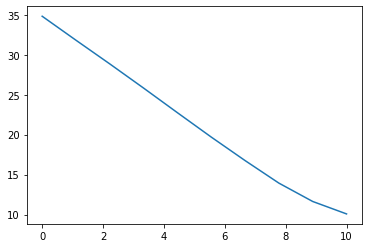

In [18]:
plt.plot( np.linspace(0.001, 10.0, nbins),wtheta)

In [14]:
len(random1['RA'])
len(data_stack['RA'])

16938694

I'm also trying to find the angular correlation function below, but also no luck.

In [6]:
#angular correlation function for mock data.  This is based on SV3 so use different randoms 

import numpy as np
import Corrfunc
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.utils import convert_to_native_endian 

 

array = convert_to_native_endian (array, warn=False) 

# Read the supplied galaxies on a periodic box
#f = fits.open('/global/cscratch1/sd/mjwilson/desi/BGS/lumfn/MXXL/bright_v0.9.fits')
#mxxl=f[1].data

RA = convert_to_native_endian(data_stack['RA'][:1000])
DEC = convert_to_native_endian(data_stack['DEC'][:1000])

# Read the supplied randoms catalog
f = fits.open('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits')
random1=f[1].data

rand_RA = random1['RA'][:1000]
rand_DEC = random1['DEC'][:1000]
rand_N = len(rand_RA)

# Setup the bins
nbins = 10
bins = np.linspace(0.001, 10.0, nbins + 1) # note the +1 to nbins

# Number of threads to use
nthreads = 2

# Auto pair counts in DD
autocorr=1
DD_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC)

# Cross pair counts in DR
autocorr=0
DR_counts = DDtheta_mocks(autocorr, nthreads, bins,RA, DEC,RA2=rand_RA, DEC2=rand_DEC)

# Auto pairs counts in RR
autocorr=1
RR_counts = DDtheta_mocks(autocorr, nthreads, bins, rand_RA, rand_DEC)

# All the pair counts are done, get the angular correlation function
wtheta = convert_3d_counts_to_cf(N, N, rand_N, rand_N, DD_counts, DR_counts,DR_counts, RR_counts)

NameError: name 'array' is not defined